**Importing Libraries**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [ ]:
encodings_to_try = ['utf-8', 'latin-1', 'cp1252']
for encoding in encodings_to_try:
    try:
        df=pd.read_csv('training.csv',encoding=encoding)
        break
    except UnicodeDecodeError:
        continue


# **Reading csv file**


In [ ]:
df.shape

(989370, 6)

In [ ]:
print(df.columns)

Index(['polarity of tweet ', 'id of the tweet', 'date of the tweet', 'query',
       'user', 'text of the tweet '],
      dtype='object')


In [ ]:
df.head(2)

polarity of tweet   id of the tweet             date of the tweet  \
0                   0       1467810672  Mon Apr 06 22:19:49 PDT 2009   
1                   0       1467810917  Mon Apr 06 22:19:53 PDT 2009   

      query           user                                 text of the tweet   
0  NO_QUERY  scotthamilton  is upset that he can't update his Facebook by ...  
1  NO_QUERY       mattycus  @Kenichan I dived many times for the ball. Man...

In [ ]:
df.isnull().sum()

polarity of tweet     0
id of the tweet       0
date of the tweet     0
query                 0
user                  0
text of the tweet     0
dtype: int64

In [ ]:
df.fillna('Nothing',inplace=True)

# Simplify the data

In [ ]:
df.columns=['sentiment','id','date','query','username','text']

# Analysis

In [ ]:
# df.shape
df['sentiment'].value_counts()

0    799996
4    189374
Name: sentiment, dtype: int64

<Axes: xlabel='sentiment', ylabel='Count'>

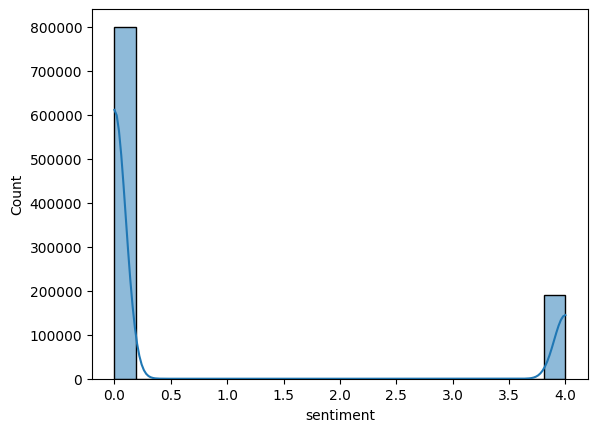

In [ ]:
sns.histplot(df['sentiment'],kde=True)

In [ ]:
fig=px.histogram(df['sentiment'])
fig.show()

# *dropping unnecessary columns*

In [ ]:
df['query'].value_counts()
df.drop(columns='query',inplace=True)

In [ ]:
text=df['text']
text_len=[len(t.split()) for t in text.values]
# text_len
text_lens=np.mean(text_len) #taking mean length of text
text_lens

13.436043138562924

## **EDA**

Text(0.5, 1.0, 'Distribution of tweets')

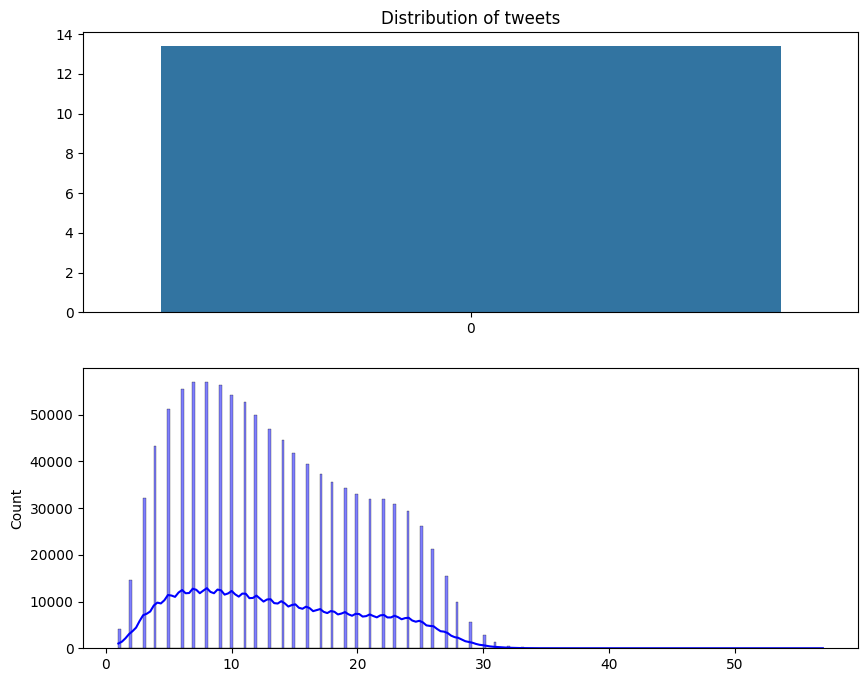

In [ ]:
fig,axes=plt.subplots(2,1,figsize=(10,8))
# axes[0].set_title('Distribution of tweets')
sns.barplot(text_len,ax=axes[0])
sns.histplot(text_len,kde=True,ax=axes[1],color='blue')
axes[0].set_title('Distribution of tweets')
# plt.annotate("mean",xy=(text_lens,5000))

In [ ]:
from string import punctuation
# from nltk.tokenize import word_tokenize
# from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer
# from nltk.stem.wordnet import WordNetLemmatizer
import nltk
# nltk.download('stopwords')

from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer
removed_stuff = list(stopwords.words('english'))+list(punctuation)
# print(stuff_to_be_removed)
stemmer = LancasterStemmer()
corpus = df['text'].tolist()
print(len(corpus))
print(corpus[0])

989370
is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
from nltk.stem.wordnet import WordNetLemmatizer
import re
nltk.download('wordnet')
final_corpus = []
final_corpus_joined = []
for i in df.index:
    text = re.sub('[^a-zA-Z]', ' ', df['text'][i])
    text = text.lower()
    text=re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",text)
    text=re.sub("(\\d|\\W)+"," ",text)
    text = text.split()
    lem = WordNetLemmatizer()
    text = [lem.lemmatize(word) for word in text  if not word in removed_stuff]
    text1 = " ".join(text)
    final_corpus.append(text)
    final_corpus_joined.append(text1)


[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
data_clean=pd.DataFrame()
data_clean["text"]=final_corpus_joined
data_clean["sentiment"]=df["sentiment"].values

In [ ]:
data1=pd.DataFrame()
data1['text']=final_corpus
data1['sentiment']=df['sentiment'].values
data1.head()

text  sentiment
0  [upset, update, facebook, texting, might, cry,...          0
1  [kenichan, dived, many, time, ball, managed, s...          0
2             [whole, body, feel, itchy, like, fire]          0
3              [nationwideclass, behaving, mad, see]          0
4                            [kwesidei, whole, crew]          0

In [ ]:
positive=data1[data1['sentiment']==4]
positive_list=positive['text'].tolist()
negative=data1[data1['sentiment']==0]
negative_list=negative['text'].tolist()

In [ ]:
positive_all=" ".join([word for sent in positive_list for word in sent])
negative_all=" ".join([word for sent in negative_list for word in sent])
# len(positive_all)

# Word cloud positive data

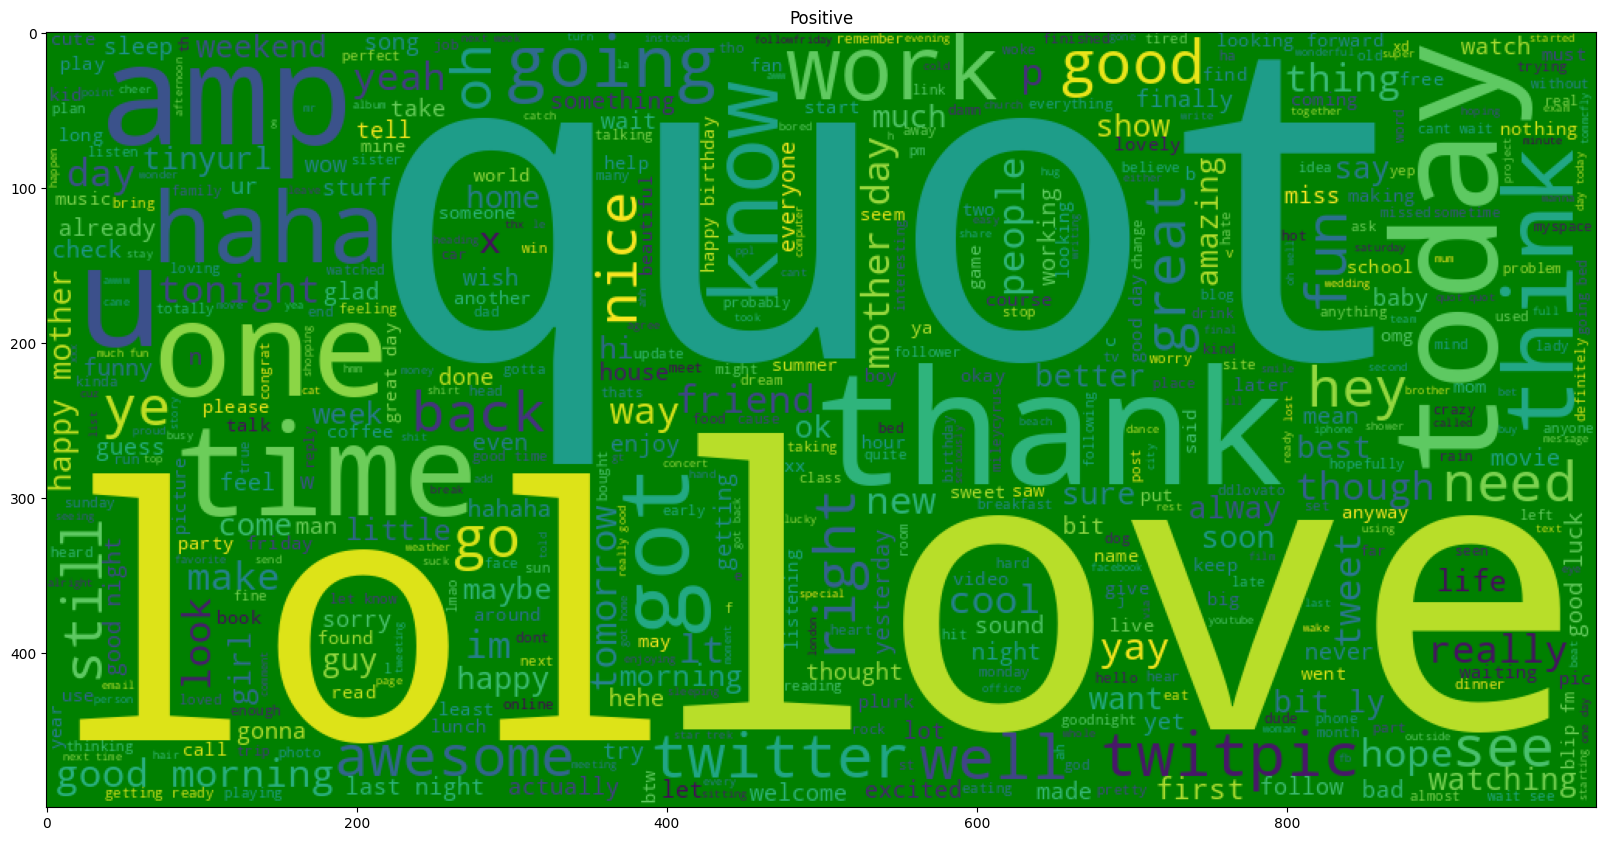

In [ ]:
from wordcloud import WordCloud
WordCloud()
wordcloud=WordCloud(width=1000,height=500,background_color='green',max_words=500).generate(positive_all)
plt.figure(figsize=(20,15))
plt.imshow(wordcloud)
plt.title("Positive")
plt.show()

# Word cloud Negative data

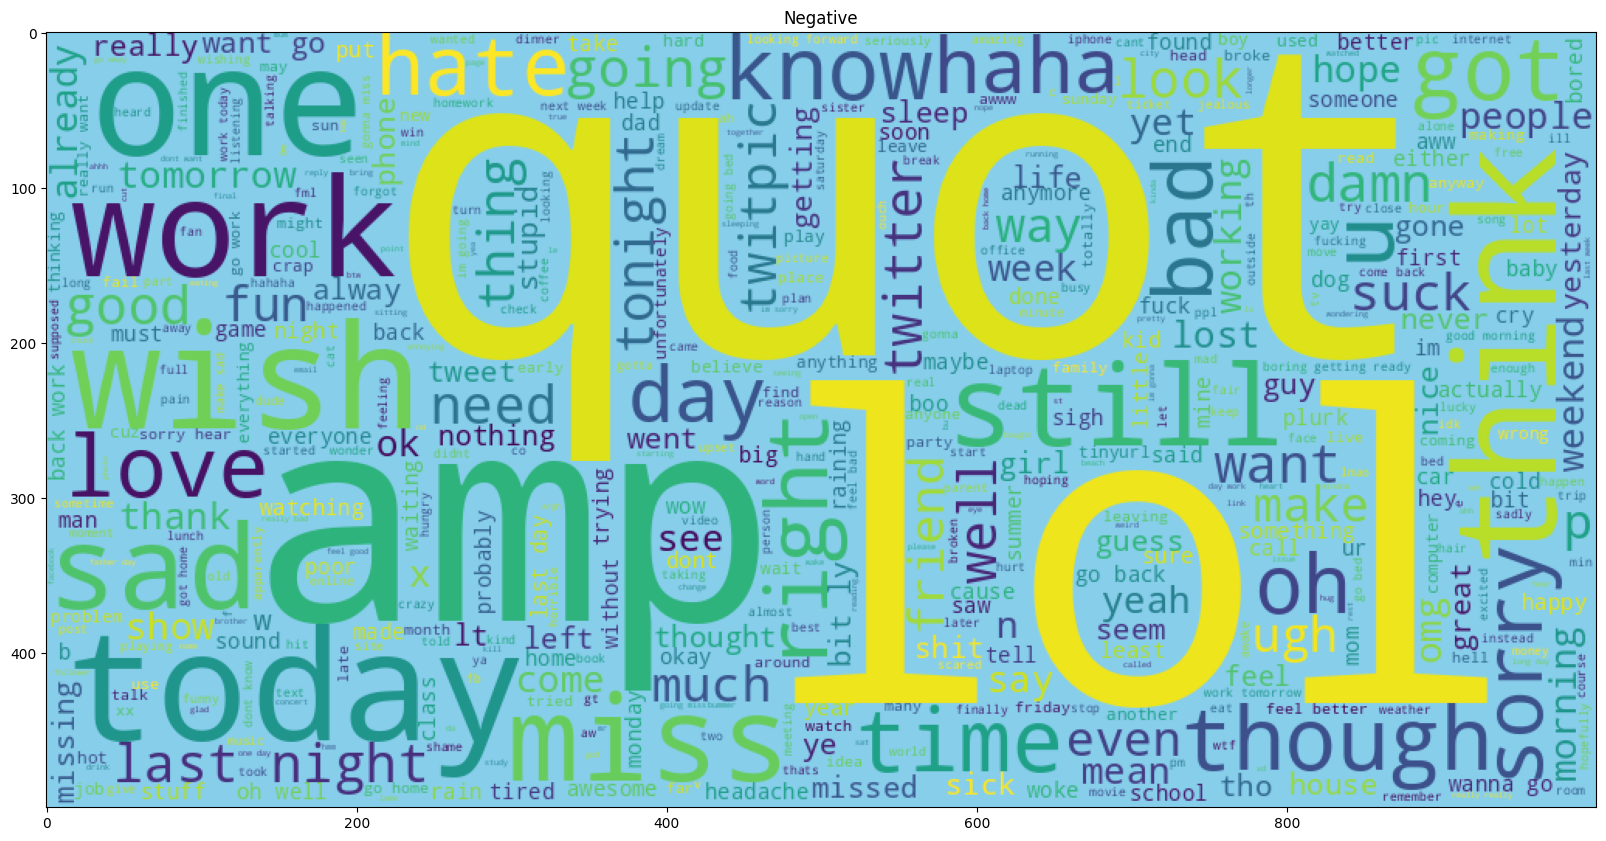

In [ ]:
from wordcloud import WordCloud
WordCloud()
wordcloud=WordCloud(width=1000,height=500,background_color='skyBlue',max_words=500).generate(negative_all)
plt.figure(figsize=(20,15))
plt.imshow(wordcloud)
plt.title("Negative")
plt.show()

# TFIDF for sentiment analysis

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf=TfidfVectorizer()
x=tfidf.fit_transform(data_cleaned['text'])
y=data_cleaned['sentiment']

# Train Test Split

In [ ]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3)

# *LogisticRegression*

In [ ]:
from sklearn.linear_model import LogisticRegression
model0=LogisticRegression()
model0.fit(x_train,y_train)
pred0=model0.predict(x_test)

In [ ]:
from sklearn.metrics import accuracy_score,confusion_matrix
accuracy_score(y_test,pred0)*100


83.31669697239423

# Accuracy Score:~ 84%

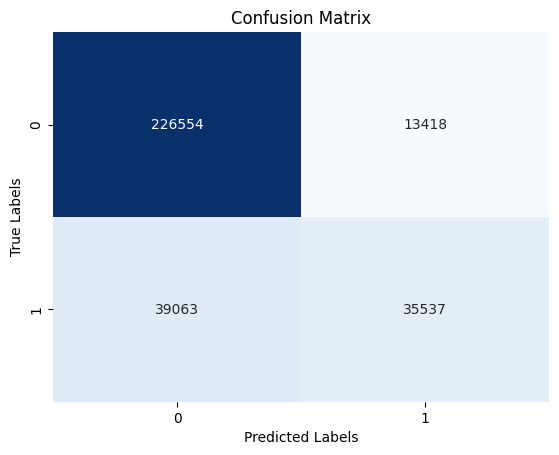

In [ ]:
cm = confusion_matrix(y_test, pred0)

# Display the confusion matrix as a heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
from sklearn.metrics import f1_score,precision_score, recall_score
precision = precision_score(y_test, pred0, pos_label=4)
recall = recall_score(y_test, pred0, pos_label=4)
print("Precision:", precision)
print("Recall:", recall)

Precision: 0.7259115514247778
Recall: 0.4763672922252011


In [ ]:
f1_score = 2 * (precision * recall) / (precision + recall)
print("F1 score:", f1_score)

F1 score: 0.5752417951519566
